# Importation des librairies nécessaires

In [83]:
import requests
import re 
import pickle
import pandas as pd
import numpy as np

import statsmodels.api as sm #librairie pour la regression

#librairies pour les graphique
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

# Quelques fonctions utiles

In [3]:
def get_page_source_content(url):
    """Retourne le code source de la page dont l'url est donnée en entrée
    
    Arguments:
        url {str} -- Lien URL du site où sont scrapées les articles
    
    Returns:
        str -- L'url de l'article concerné
    """
    return requests.get(url).text

In [21]:
def get_links(content):
    """Retourne une liste contenant tous les urls des articles trouvés sur la page "SurfShop" à partir du contenu
    
    Arguments:
        content {str} -- Contenu html de la page "SurfShop"
    
    Returns:
        list -- Liste exhaustive des urls
    """
    pattern = '<a class="product_manu_link" href="(.*)" item'
    output = re.findall(pattern, content)
    print('First link : ', output[0])
    return output

In [47]:
def save_html_contents(all_links, file_name):
    """Sauvegarde tous les codes sources des liens des articles donnés dans la liste en entrée
    
    Arguments:
        all_links {list} -- Liste contenant les urls des articles
        file_name {str} -- Nom qu'il faut donner au fichier à sauvegarder
    """

    html_contents = []
    for url in all_links:
        html_contents.append(get_page_source_content(url))
    
    #save the html object
    with open(file_name,'wb') as file:
        pickle.dump(html_contents, file)

In [54]:
def get_thickness(page_content):
    """Retourne l'epaisseur de l'article concerné à partir de son code source.
       Pour les cas particuliers des articles qui n'ont pas l'épaisseur indiquée
       au bon endroit, la fonction retourne une valeur vide. Ces valeurs seront 
       plus tard supprimés de la base finale pour éviter les valeurs manquantes.
    
    Arguments:
        page_content {str} -- page source d'un article.
    
    Returns:
        int -- Taille en millimètre de l'habit concerné.
    """
    try: #
        return int(re.findall('<p class="noh">(.*)</p>', page_content)[0][0])
    except:
        return None

In [59]:
def get_price(page_content):
    """Retourne le prix d'un article 
       Pour les cas particuliers des articles qui n'ont pas le prix indiqué
       au bon endroit, la fonction retourne une valeur vide. Ces valeurs seront 
       plus tard supprimés de la base finale pour éviter les valeurs manquantes.
    
    Arguments:
        page_content {str} -- page source d'un article de ProShop.
    
    Returns:
        float -- Le prix en euro de l'article
    """
    try:
        return float(re.findall('<span class="price" id="prod(.*) itemprop="price">\n(.*)<',page_content)[0][1].strip()[:5].replace(',','.'))
    except:
        return None

# 1. Récupération de tous les liens des articles (à stocker comme identifiant)

## 1.1. Site "SurfShop"

In [15]:
# Récupération du contenu de la 1ere page contenant la liste des articles
surf_content = get_page_source_content(url='http://www.surfshop.fr/neoprene-72/combinaisons-homme-73#/')

In [22]:
# Extraction des liens individuels des articles grâce aux expressions régulières
output  = get_links(surf_content)

First link :  http://www.surfshop.fr/lifestyle-450/cartes-cadeaux-505/surfshopfr-carte-cadeau-6529.html


In [78]:
# Retrouver le lien de la page suivante pour la suite des articles suivants
next_page_pattern = 'href="(.*?)">\n\t*<b>Suivant</b>'
next_link=re.findall(next_page_pattern, surf_content)[0]
next_link = 'http://www.surfshop.fr/' + next_link
next_link

'http://www.surfshop.fr//neoprene-72/combinaisons-homme-73?p=2'

In [24]:
output2 = get_links(content=get_page_source_content(url=next_link))

First link :  http://www.surfshop.fr/neoprene-72/combinaisons-homme-73/3-2mm-76/np-surf-mission-front-zip-3-2-5676.html


In [31]:
# Concaténation des liens collectés
url_ids = output + output2

#Affichage des 3 premiers et des 3 derniers liens collectés
url_ids[:3], url_ids[-3:]

(['http://www.surfshop.fr/lifestyle-450/cartes-cadeaux-505/surfshopfr-carte-cadeau-6529.html',
  'http://www.surfshop.fr/neoprene-72/combinaisons-homme-73/3-2mm-76/np-surf-fullsuit-manches-courtes-3-2-fl-5640.html',
  'http://www.surfshop.fr/neoprene-72/combinaisons-homme-73/3-2mm-76/np-surf-fullsuit-manches-courtes-3-2-fl-5654.html'],
 ['http://www.surfshop.fr/neoprene-72/combinaisons-homme-73/etanches-560/mystic-force-drysuit-10326.html',
  'http://www.surfshop.fr/neoprene-72/combinaisons-homme-73/etanches-560/mystic-vulcanic-neoprene-drysuit-9305.html',
  'http://www.surfshop.fr/neoprene-72/combinaisons-homme-73/ion-fuse-drysuit-etanche-43-dl-3747.html'])

In [34]:
# Sauvegarde de l'object contenant la liste des URLs
with open('Liste_urls_SurfShop','wb') as file:
    pickle.dump(url_ids, file)

## 1.2. Site "ProShop"

In [37]:
pro_content = get_page_source_content(url='https://glisse-proshop.com/neoprene/combinaisons-homme.html?p=1')
nb_pages = int(re.findall('<span class="product-name">Page suivante \((.*)\)</span>', pro_content)[0].split('/')[1])
nb_pages

9

Il y a 9 pages en tout concernant les articles pour homme. Nous allons les parcourir un à un pour récupérer les liens des articles.

In [38]:
proshop_links = []
for num_page in range(1, nb_pages+1):
    content=get_page_source_content(url='https://glisse-proshop.com/neoprene/combinaisons-homme.html?p=%s'%num_page)
    
    #faire attention, les 3 prmiers ne font pas parti
    for link in re.findall('<a href="(.*) class="product-image">', content)[3:]:
        proshop_links.append(link.split('" ')[0])

In [39]:
#save the urls
with open('proshop_urls_list','wb') as file:
    pickle.dump(proshop_links, file)

# 2. Récupération du code source de chaque article via les urls collectés

**Remarque** : Lancer cette partie prend énormément de temps vu que nous allons récupérer toutes les pages sources de tous les articles. Si les fichiers ces codes sources sont déjà présents dans le disque dur, sautez cette partie et allez directement à la partie 3. 

## 2.1. Le site SurfShop

In [48]:
with open("./Liste_urls_SurfShop", "rb") as input_file:
    surf_urls_list = pickle.load(input_file)

In [49]:
# Il y a 381 articles venant de ce site
len(surf_urls_list)

381

In [50]:
save_html_contents(all_links=surf_urls_list, file_name='surfshop_htmls')

## 2.2. Le site ProShop

In [51]:
with open("./proshop_urls_list", "rb") as input_file:
    pro_urls_list = pickle.load(input_file)

In [52]:
# Il y a 400 articles venant de ce site
len(pro_urls_list)

400

In [ ]:
save_html_contents(all_links=pro_urls_list, file_name='proshop_htmls')

# 3. Extraction des informations utiles à partir de la page source

# 3.1. Données de SurfShop

In [53]:
with open("./surfshop_htmls", "rb") as input_file:
    surfshop_htmls = pickle.load(input_file)

In [55]:
prices_list, thickness_list, brand_list = [], [], []
price_pattern = 'itemprop="price">(.*)</span>'
for page_content in surfshop_htmls[1:]:
    thickness_list.append(get_thickness(page_content))
    prices_list.append(float(re.findall(price_pattern, page_content)[0]))
    
    # Suite à un problème d'encoding, on remplace "&#039" par apostrophe (*'*).
    # .strip() permet de supprimer les espaces vides se trouvant devant le nom de la marque obtenue
    brand_list.append(re.findall(' (.*)\r\n(.*)<span class="text-orange">', page_content)[0][0].strip().replace("&#039;","'"))

In [56]:
surf_shop_df = pd.DataFrame({'Thickness':thickness_list, 'Brand':brand_list, 'Price':prices_list, 'Source':'SurfShop'}).dropna().reset_index(drop=True)
surf_shop_df.sample(7, random_state=42)

Thickness    Brand   Price    Source
165        3.0   Mystic  249.99  SurfShop
33         3.0      Ion  146.96  SurfShop
15         5.0  NP surf  119.95  SurfShop
312        4.0   Mystic  359.99  SurfShop
57         4.0      Ion  179.95  SurfShop
219        4.0      Ion  247.96  SurfShop
76         5.0      Ion  189.95  SurfShop

## 3.2. Données de "ProShop"

In [57]:
with open("./proshop_htmls", "rb") as input_file:
    proshop_htmls = pickle.load(input_file)

In [60]:
prices_list, thickness_list, brand_list = [], [], []
for page_content in proshop_htmls:
    thickness_list.append(re.findall('<li>Epaisseur (.*)</li>', page_content)[0][0])
    brand_list.append(re.findall('<img class="image-responsive" alt="(.*)" src=',page_content)[0].capitalize())
    prices_list.append(get_price(page_content))

In [61]:
pro_shop_df = pd.DataFrame({'Thickness':thickness_list, 'Brand':brand_list, 'Price':prices_list, 'Source':'ProShop'}).dropna().reset_index(drop=True)
pro_shop_df.sample(7, random_state=42)

Thickness     Brand   Price   Source
175         4       Ion  293.90  ProShop
180         5  Rip curl  314.90  ProShop
111         3    Hurley  189.90  ProShop
65          2       Ion  154.90  ProShop
101         4      Xcel  181.90  ProShop
15          3       Ion  104.90  ProShop
9           2       Ion   79.95  ProShop

## 3.3. Fusion des données

In [63]:
final_data = pd.concat([surf_shop_df, pro_shop_df], ignore_index=True)
final_data.sample(7, random_state=1)

Thickness     Brand   Price    Source
440         4       Ion  159.90   ProShop
530         4   Picture  244.90   ProShop
346         5    Mystic  429.99  SurfShop
323         5    Mystic  369.99  SurfShop
474         5  Rip curl  189.90   ProShop
360         6    Mystic  449.99  SurfShop
29          3   O'Neill  144.95  SurfShop

In [64]:
final_data.shape

(558, 4)

Nous avons en tout 558 articles


In [65]:
final_data.Source.value_counts()

SurfShop    368
ProShop     190
Name: Source, dtype: int64

Il y a 368 articles venant SurFShop et 190 de ProShop que nous allons analyser.

# 4. Analyse des données

## 4.1. Répartition du nombre d'occurences des marques collectées

In [77]:
s = final_data.Brand.value_counts()[::-1]
data  = [go.Bar(
            x=s.values,
            y=s.index,
            orientation = 'h'
)]
iplot(go.Figure(data, layout=go.Layout(title='Fréquence des marques dans la base de données globale')))

## 4.2. Histogramme des prix selon la source des articles

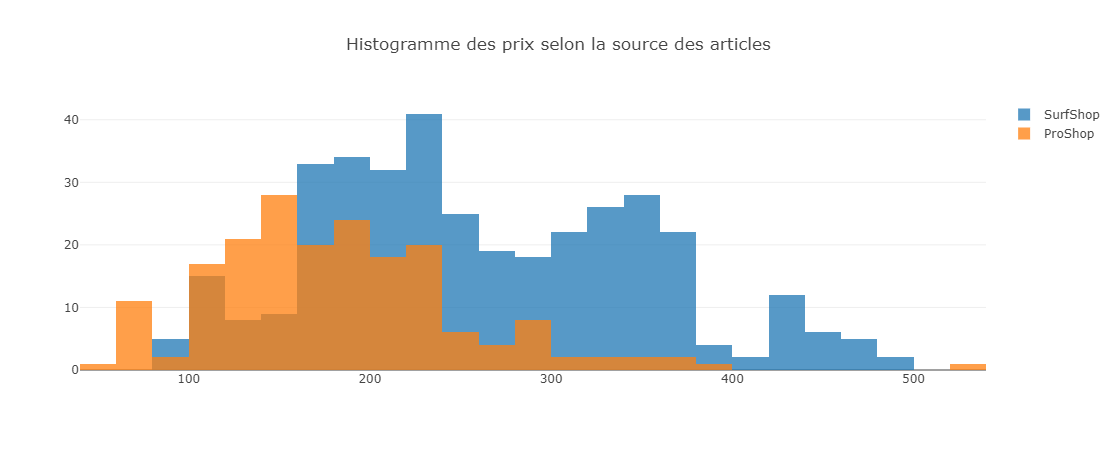

In [75]:
surf = go.Histogram(
    x=final_data.Price[final_data.Source == 'SurfShop'] ,
    opacity=0.75,
    name = 'SurfShop'
)
pro = go.Histogram(
    x=final_data.Price[final_data.Source == 'ProShop'],
    opacity=0.75,
    name = 'ProShop'
)

data3 = [surf, pro]
layout = go.Layout(barmode='overlay', title='Histogramme des prix selon la source des articles')
fig = go.Figure(data=data3, layout=layout)

iplot(fig, filename='overlaid histogram')

## 4.3. Boxplot des prix en fonction des marques

In [98]:
traces = []
for brand in final_data.Brand.unique():
    traces.append(
        go.Box(
            x=final_data.Price[final_data.Brand == brand],
            name=brand
        )
    )
iplot(traces)

Pas de relation apparente entre la marque du vêtement et le prix.

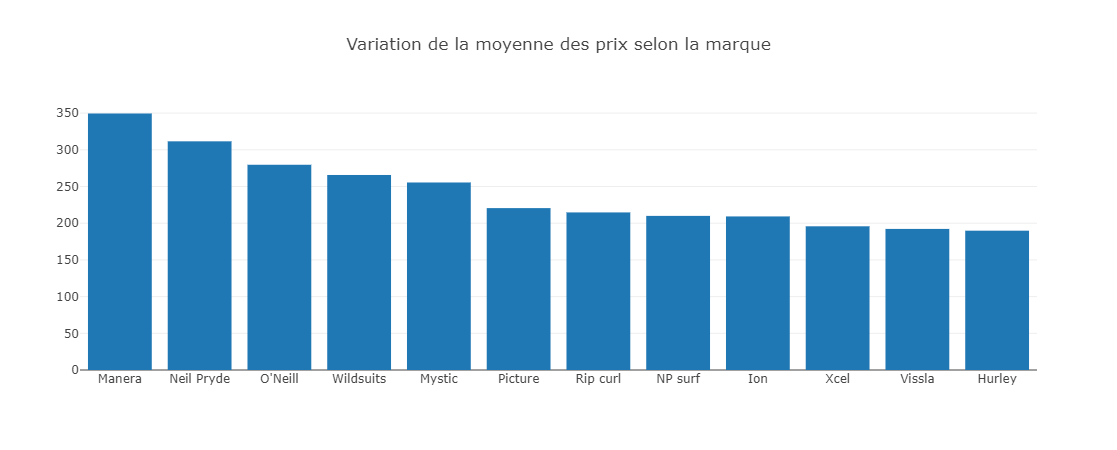

In [106]:
s2 = final_data.groupby('Brand').Price.agg('mean').sort_values(ascending=False)
data  = [go.Bar(
            y=s2.values,
            x=s2.index
)]
iplot(go.Figure(data, layout=go.Layout(title='Variation de la moyenne des prix selon la marque')))

Nous remarquons que la marque n'a pas un grand impact sur le prix, vu que le prix moyen de change pas drastiquement selon la marque à partir du graphe précédent.

On peut également faire un test d'égalité des moyennes selon les marques pour confirmer qu'elles ne sont pas significativement différentes.

# 5. Analyse économétrique

In [87]:
# Création de la variable binaire.
# 1 désigne que la source est SurfShop et 0 désigne ProShop
final_data["from_surf"] = np.where(final_data.Source == "SurfShop", 1, 0)
final_data.sample(3, random_state=2)

Thickness    Brand   Price    Source  from_surf
550         4     Xcel  321.90   ProShop          0
469         4     Xcel  181.90   ProShop          0
120         3  O'Neill  219.95  SurfShop          1

In [91]:
Y = final_data.Price
X = sm.add_constant(final_data[["Thickness", "from_surf"]])
model = sm.OLS(endog=Y, exog=X.astype(float))
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     134.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.04e-48
Time:                        21:11:29   Log-Likelihood:                -3206.1
No. Observations:                 558   AIC:                             6418.
Df Residuals:                     555   BIC:                             6431.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.8227     12.615      4.504      0.0

A commenter...